In [28]:
import rasterio
from rasterio.enums import Resampling
import numpy as np
import scipy.ndimage

def downscale_raster(input_path, output_path, target_size=(100, 100), method='bilinear'):
    """Downscales a raster to the target size and saves it as a new file."""
    # Open the input raster
    with rasterio.open(input_path) as src:
        data = src.read(1)  # Read the first band
        transform = src.transform

        # Get the original dimensions
        height, width = data.shape

        # Choose resampling method
        resampling_methods = {
            'nearest': Resampling.nearest,
            'bilinear': Resampling.bilinear,
            'cubic': Resampling.cubic
        }
        resampling_method = resampling_methods.get(method, Resampling.bilinear)

        # Resample using rasterio
        scale_x = target_size[1] / width
        scale_y = target_size[0] / height

        downsampled_data = scipy.ndimage.zoom(data, (scale_y, scale_x), order=1 if method == 'bilinear' else 0)

        # Update transform for the new resolution
        new_transform = transform * transform.scale((width / target_size[1]), (height / target_size[0]))

        # Save the downsampled raster
        with rasterio.open(
            output_path,
            'w',
            driver='GTiff',
            height=target_size[0],
            width=target_size[1],
            count=1,
            dtype=downsampled_data.dtype,
            crs=src.crs,
            transform=new_transform
        ) as dst:
            dst.write(downsampled_data, 1)

    print(f"Downscaled raster saved to {output_path}")

# Example usage
downscale_raster('/Users/lucasguthrieallan/Desktop/GISSTUFF/studyareacombined.tif', '/Users/lucasguthrieallan/Desktop/GISSTUFF/studyareadownscaled.tif', target_size=(100, 100), method='bilinear')
downscale_raster('/Users/lucasguthrieallan/Desktop/GISSTUFF/Newareauplift.tif', '/Users/lucasguthrieallan/Desktop/GISSTUFF/Newareauplift.tif', target_size=(100, 100), method='bilinear')


Downscaled raster saved to /Users/lucasguthrieallan/Desktop/GISSTUFF/studyareadownscaled.tif
Downscaled raster saved to /Users/lucasguthrieallan/Desktop/GISSTUFF/Newareauplift.tif


In [29]:
import rasterio
import numpy as np
import xarray as xr
import scipy.ndimage

# Set seed for reproducibility
np.random.seed(42)

def downscale_and_add_random_noise(input_path, target_size=(100, 100), method='bilinear', noise_std=50):
    """Downscales a raster, adds random noise, and returns the data as a NumPy array."""
    with rasterio.open(input_path) as src:
        data = src.read(1)  # Read first band
        transform = src.transform

        # Original size
        height, width = data.shape

        # Define scaling factors
        scale_x = target_size[1] / width
        scale_y = target_size[0] / height

        # Choose interpolation method
        interpolation_order = 1 if method == 'bilinear' else 0  # 1 = linear, 0 = nearest
        downsampled_data = scipy.ndimage.zoom(data, (scale_y, scale_x), order=interpolation_order)

        # Generate and add random noise
        noise = np.random.normal(0, noise_std, downsampled_data.shape)
        noisy_data = downsampled_data + noise
        noisy_data = np.maximum(noisy_data, 0)  # Ensure no negative values

        return noisy_data

def save_as_netcdf(data, output_path, var_name, long_name, units):
    """Saves a 2D NumPy array as a NetCDF file."""
    x = np.arange(data.shape[1])  # X-axis
    y = np.arange(data.shape[0])  # Y-axis
    ds = xr.Dataset(
        {var_name: (["y", "x"], data, {"long_name": long_name, "units": units})},
        coords={"x": x, "y": y}
    )
    ds.to_netcdf(output_path)
    print(f"Saved NetCDF: {output_path}")

# File paths
dem_input = '/Users/lucasguthrieallan/Desktop/GISSTUFF/studyareacombined.tif'
uplift_input = '/Users/lucasguthrieallan/Desktop/GISSTUFF/Newareauplift.tif'
dem_output = '/Users/lucasguthrieallan/Desktop/GISSTUFF/downscaled_dem.nc'
uplift_output = '/Users/lucasguthrieallan/Desktop/GISSTUFF/downscaled_uplift.nc'

# Downscale and add random noise
dem_data = downscale_and_add_random_noise(dem_input, noise_std=50)  # Larger noise for elevation
uplift_data = downscale_and_add_random_noise(uplift_input, noise_std=0.005)  # Small noise for uplift rates

# Save as NetCDF
save_as_netcdf(dem_data, dem_output, var_name="elevation", long_name="Digital Elevation Model", units="meters")
save_as_netcdf(uplift_data, uplift_output, var_name="uplift_rate", long_name="Uplift Rate", units="mm/year")

# Print sample values
print("\nSample DEM values:")
print(dem_data[0:5, 0:5])

print("\nSample Uplift Rate values:")
print(uplift_data[0:5, 0:5])


Saved NetCDF: /Users/lucasguthrieallan/Desktop/GISSTUFF/downscaled_dem.nc
Saved NetCDF: /Users/lucasguthrieallan/Desktop/GISSTUFF/downscaled_uplift.nc

Sample DEM values:
[[24.83570765  0.         32.38442691 76.15149282  0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [17.88936802 28.03922632 54.15256216 52.6901026   0.        ]
 [ 0.          0.         37.36468026 30.51851327  0.        ]
 [ 0.          0.          0.26218499  2.34902969  0.        ]]

Sample Uplift Rate values:
[[0.01737313 0.01925871 0.01781991 0.0213801  0.02683565]
 [0.02774995 0.02174485 0.01024761 0.01741287 0.0165099 ]
 [0.02213647 0.02176666 0.02316006 0.02100897 0.02074917]
 [0.03017012 0.01576291 0.03010493 0.01585812 0.02189556]
 [0.02026987 0.02020922 0.02660979 0.0207056  0.01854217]]


Saved NetCDF: /Users/lucasguthrieallan/Desktop/GISSTUFF/downscaled_dem.nc
Saved NetCDF: /Users/lucasguthrieallan/Desktop/GISSTUFF/downscaled_uplift.nc


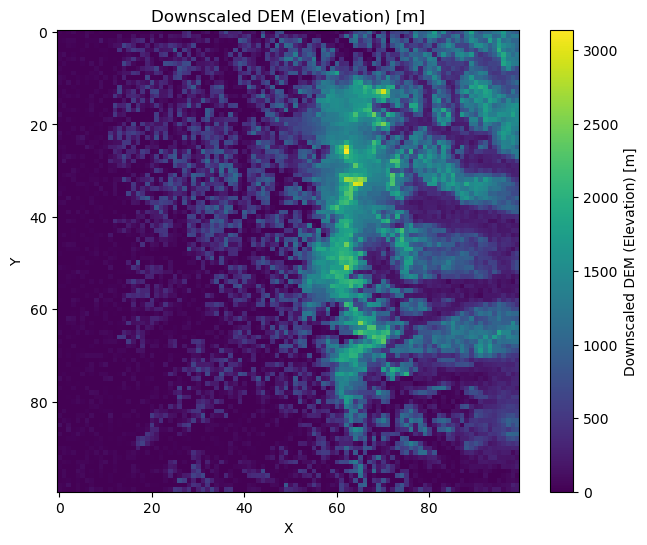

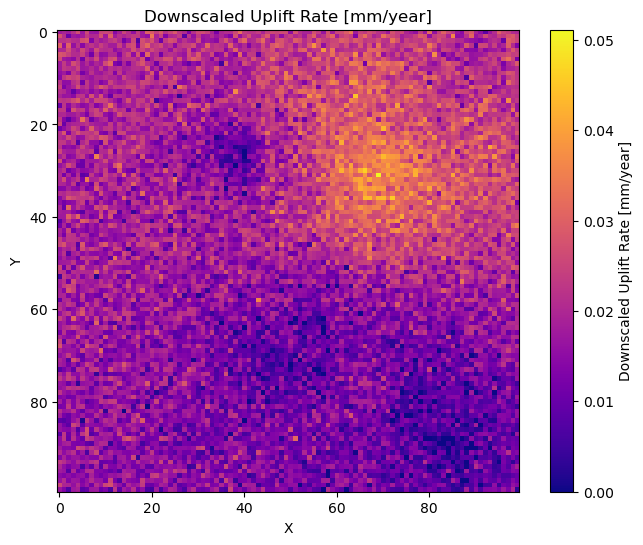


Sample DEM values:
[[24.83570765  0.         32.38442691 76.15149282  0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [17.88936802 28.03922632 54.15256216 52.6901026   0.        ]
 [ 0.          0.         37.36468026 30.51851327  0.        ]
 [ 0.          0.          0.26218499  2.34902969  0.        ]]

Sample Uplift Rate values:
[[0.01737313 0.01925871 0.01781991 0.0213801  0.02683565]
 [0.02774995 0.02174485 0.01024761 0.01741287 0.0165099 ]
 [0.02213647 0.02176666 0.02316006 0.02100897 0.02074917]
 [0.03017012 0.01576291 0.03010493 0.01585812 0.02189556]
 [0.02026987 0.02020922 0.02660979 0.0207056  0.01854217]]


In [30]:
import rasterio
import numpy as np
import xarray as xr
import scipy.ndimage
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

def downscale_and_add_random_noise(input_path, target_size=(100, 100), method='bilinear', noise_std=50):
    """Downscales a raster, adds random noise, and returns the data as a NumPy array."""
    with rasterio.open(input_path) as src:
        data = src.read(1)  # Read first band
        transform = src.transform

        # Original size
        height, width = data.shape

        # Define scaling factors
        scale_x = target_size[1] / width
        scale_y = target_size[0] / height

        # Choose interpolation method
        interpolation_order = 1 if method == 'bilinear' else 0  # 1 = linear, 0 = nearest
        downsampled_data = scipy.ndimage.zoom(data, (scale_y, scale_x), order=interpolation_order)

        # Generate and add random noise
        noise = np.random.normal(0, noise_std, downsampled_data.shape)
        noisy_data = downsampled_data + noise
        noisy_data = np.maximum(noisy_data, 0)  # Ensure no negative values

        return noisy_data

def save_as_netcdf(data, output_path, var_name, long_name, units):
    """Saves a 2D NumPy array as a NetCDF file."""
    x = np.arange(data.shape[1])  # X-axis
    y = np.arange(data.shape[0])  # Y-axis
    ds = xr.Dataset(
        {var_name: (["y", "x"], data, {"long_name": long_name, "units": units})},
        coords={"x": x, "y": y}
    )
    ds.to_netcdf(output_path)
    print(f"Saved NetCDF: {output_path}")

def plot_data(data, title, cmap="viridis"):
    """Plots a 2D dataset using matplotlib."""
    plt.figure(figsize=(8, 6))
    plt.imshow(data, cmap=cmap, origin="upper")
    plt.colorbar(label=title)
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

# File paths
dem_input = '/Users/lucasguthrieallan/Desktop/GISSTUFF/studyareacombined.tif'
uplift_input = '/Users/lucasguthrieallan/Desktop/GISSTUFF/Newareauplift.tif'
dem_output = '/Users/lucasguthrieallan/Desktop/GISSTUFF/downscaled_dem.nc'
uplift_output = '/Users/lucasguthrieallan/Desktop/GISSTUFF/downscaled_uplift.nc'

# Downscale and add random noise
dem_data = downscale_and_add_random_noise(dem_input, noise_std=50)  # Elevation noise level
uplift_data = downscale_and_add_random_noise(uplift_input, noise_std=0.005)  # Uplift noise level

# Save as NetCDF
save_as_netcdf(dem_data, dem_output, var_name="elevation", long_name="Digital Elevation Model", units="meters")
save_as_netcdf(uplift_data, uplift_output, var_name="uplift_rate", long_name="Uplift Rate", units="mm/year")

# Plot the results
plot_data(dem_data, "Downscaled DEM (Elevation) [m]")
plot_data(uplift_data, "Downscaled Uplift Rate [mm/year]", cmap="plasma")

# Print sample values
print("\nSample DEM values:")
print(dem_data[0:5, 0:5])

print("\nSample Uplift Rate values:")
print(uplift_data[0:5, 0:5])


In [33]:
import rasterio

# Open the original DEM file
dem_tif = '/Users/lucasguthrieallan/Desktop/GISSTUFF/studyareacombined.tif'  # Replace with actual path
with rasterio.open(dem_tif) as src:
    bounds = src.bounds  # Get bounding box
    transform = src.transform  # Get georeferencing info

# Calculate the center latitude
lat_center = (bounds.top + bounds.bottom) / 2
print(f"DEM is centered at approximately {lat_center:.2f}° latitude.")


DEM is centered at approximately -50.00° latitude.
